In [1]:
import numpy as np
from astropy.wcs import WCS
from astropy.coordinates import spherical_to_cartesian, cartesian_to_spherical

Taken from here:

https://github.com/dstndstn/astrometry.net/blob/main/util/fit-wcs.c

https://github.com/dstndstn/astrometry.net/blob/main/include/astrometry/fit-wcs.h#L90 (this is just the definition)

In [87]:
def make_wcs(xypositions, radecpositions):
    "Return the WCS that maps the (x, y) positions on the image to the provided (RA, Dec)."
    
    # Convert array of ra, dec into x, y, z
    ra = radecpositions[:,0] * np.pi / 180.
    dec = radecpositions[:,1] * np.pi / 180.
    starxyz = np.array([np.cos(dec) * np.cos(ra), np.cos(dec) * np.sin(ra), np.sin(dec)]).T
    
    # Find center of mass of the stars
    star_cm = np.sum(starxyz, axis=0)
    star_cm = star_cm / np.linalg.norm(star_cm)
    
    # project the stars around their center of mass
    sdotr = starxyz.dot(star_cm)
    if star_cm[2] == 1.0:
        x, y = starxyz[:,:2].T  / starxyz[:,2]
    elif star_cm[2] == -1.0:
        x, y = starxyz[:,:2].T  / starxyz[:,2]
        x *= -1.0
    else:
        # eta is a vector perpendicular to r pointing in the direction of increasing RA. eta_z = 0 by definition.
        eta = np.array([-star_cm[1], star_cm[0], 0])
        eta = eta / np.linalg.norm(eta)
        # xi =  r cross eta, a vector pointing northwards, in direction of increasing DEC
        xi = np.cross(star_cm, eta)
        # project s - r onto eta and xi.  No need to subtract r from s, though,
        # since eta and xi are orthogonal to r by construction.
        xy = (np.array([starxyz.dot(eta), starxyz.dot(xi)]) / sdotr).T

    # compute the center of mass of the projected stars and subtract it out.
    xy = xy - np.mean(xy, axis=0)

    # Find center of mass of stars
    field_cm = np.mean(xypositions, axis=0)
    xy_zero_cm = xypositions - field_cm
    
    #compute the "covariance" between field positions and projected positions of the corresponding stars.
    cov = xy_zero_cm.T.dot(xy)

    # run SVD
    U, s, vh = np.linalg.svd(cov)
    R = vh.dot(U)
    
    # compute scale in degrees make the variances equal.
    #scale = np.sqrt(np.sum(xy ** 2) / np.sum(f ** 2)) * 180. / np.pi
    scale = np.linalg.norm(xy) / np.linalg.norm(xy_zero_cm)
    scale *= 180. / np.pi
    
    wcs = WCS()
    wcs.wcs.cd = R * scale
    wcs.wcs.crpix = field_cm
    
    #xyz2radec
    x, y, z = star_cm
    ra = np.arctan2(y, x);
    if (ra < 0):
        ra += 2.0 * np.pi;
    dec = np.arcsin(z)

    # Convert to degrees
    ra = ra * 180. / np.pi
    dec = dec * 180. / np.pi

    wcs.wcs.crval = np.array([ra, dec])
    return wcs

In [4]:
radecpositions = np.array([[1., -33.0], [2., -31.0], [22., -1.3], [23., -5.0]])
xyposition = np.array([[3., 4.], [1.5, 2.7], [5.4, 1.7], [1.3, 0.9]])

In [5]:
make_wcs(radecpositions, xyposition)

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 336.1242301246682  63.20234722142846  
CRPIX : 12.0  -17.575  
CD1_1 CD1_2  : 1.3493653526518399  3.9014319983756884  
CD2_1 CD2_2  : 3.9014319983756884  -1.3493653526518385  
NAXIS : 0  0

In [ ]:
fieldxy = np.array([[3., 4.], [1.5, 2.7], [5.4, 1.7], [1.3, 0.9]])
field_cm = np.mean(fieldxy, axis=0)
f = fieldxy - field_cm
f

In [ ]:
starxyz = np.array([[3., 4., 1.1], [1.5, 2.7, 0.6], [5.4, 1.7, 0.3], [1.3, 0.9, 2.0]])
star_cm = np.sum(starxyz, axis=0)
star_cm = star_cm / np.linalg.norm(star_cm)
star_cm

In [ ]:
# project the stars around their center of mass
sdotr = starxyz.dot(star_cm)
if star_cm[2] == 1.0:
    x, y = starxyz[:,:2].T  / starxyz[:,2]
elif star_cm[2] == -1.0:
    x, y = starxyz[:,:2].T  / starxyz[:,2]
    x *= -1.0
else:
    # eta is a vector perpendicular to r pointing in the direction of increasing RA. eta_z = 0 by definition.
    eta = np.array([-star_cm[1], star_cm[0], 0])
    eta = eta / np.linalg.norm(eta)
    # xi =  r cross eta, a vector pointing northwards, in direction of increasing DEC
    xi = np.cross(star_cm, eta)
    # project s - r onto eta and xi.  No need to subtract r from s, though,
    # since eta and xi are orthogonal to r by construction.
    xy = (np.array([starxyz.dot(eta), starxyz.dot(xi)]) / sdotr).T

# compute the center of mass of the projected stars and subtract it out.
pcm = np.mean(xy, axis=0)
xy = xy - pcm
xy

In [ ]:
#compute the "covariance" between field positions and projected positions of the corresponding stars.
cov = f.T.dot(xy)
cov

In [ ]:
# run SVD
U, s, vh = np.linalg.svd(cov)
R = vh.dot(U)

In [ ]:
# compute scale: make the variances equal.
pvar = np.sum(xy ** 2)
fvar = np.sum(f ** 2)
scale = np.sqrt(pvar / fvar) * 180. / np.pi
scale

In [ ]:
wcs = WCS()
wcs.wcs.cd = R * scale
wcs.wcs.crpix = field_cm

In [ ]:
#xyz2radec
x, y, z = star_cm
ra = np.arctan2(y, x);
if (ra < 0):
    ra += 2.0 * np.pi;
dec = np.arcsin(z)

# Convert to degrees
ra = ra * 180. / np.pi
dec = dec * 180. / np.pi

wcs.wcs.crval = np.array([ra, dec])

In [ ]:
print(wcs.wcs.crval)
print(wcs.wcs.crpix)
print(wcs.wcs.cd)

# Real Example

In [22]:
import aplpy
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Angle

INFO: Auto-setting vmin to  1.248e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.126e+02 [aplpy.core]


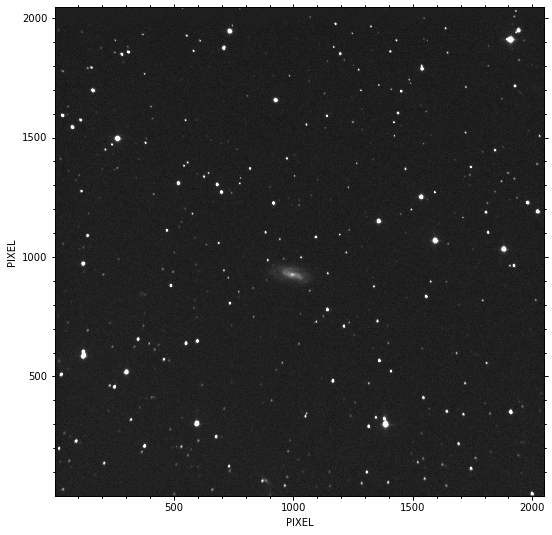

In [11]:
# Reference image
refpath = "./wcstestdata/IC2143_wcs.fits"
hdulist = fits.open(refpath)

refimg = hdulist[0].data
fig = aplpy.FITSFigure(refimg)
fig.show_grayscale()
plt.show()

In [12]:
h, w = refimg.shape
refwcs = WCS(hdulist[0])
cra, cdec = refwcs.all_pix2world([[w/2, h/2]], 0, ra_dec_order=True)[0]

### Find Sources with Gaia

In [20]:
# point = SkyCoord("05h35m17.3s -05d23m28s", frame='icrs')
frame_center = SkyCoord(cra, cdec, unit='deg')
fov_rad = 10 * u.arcminute


MAX_REF_STARS = 5
q = Gaia.cone_search_async(frame_center, fov_rad)
result_table = q.get_results()
result_table.sort("phot_g_mean_mag")
result_table = result_table[:MAX_REF_STARS]

INFO: Query finished. [astroquery.utils.tap.core]


In [23]:
# Flatten RA, Dec into list of bare degree numbers
ra_refobjs = [Angle(ra, unit="degree").degree for ra in result_table["ra"]]
dec_refobjs = [Angle(dec, unit="degree").degree for dec in result_table["dec"]]

In [37]:
radecpositions = np.array([*zip(ra_refobjs, dec_refobjs)])
xypositions = refwcs.all_world2pix(radecpositions, 0)

In [47]:
radecpositions

array([[ 86.70731141, -18.68525339],
       [ 86.70262025, -18.70209746],
       [ 86.74079299, -18.72525273],
       [ 86.73351421, -18.70435706],
       [ 86.70424206, -18.71810926]])

In [48]:
xypositions

array([[ 913.51886131, 1223.55810907],
       [ 879.47946597, 1101.76563007],
       [1139.33443573,  929.9915394 ],
       [1091.54402642, 1082.33776798],
       [ 888.92934595,  985.4157568 ]])

In [54]:
estwcs = make_wcs(xypositions, radecpositions)
estwcs

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 86.71769555837326  -18.707014670571276  
CRPIX : 982.5612270761718  1064.613760662782  
CD1_1 CD1_2  : 0.00013779965598229092  -1.9993633623716647e-06  
CD2_1 CD2_2  : 1.9993633623716265e-06  0.00013779965598229087  
NAXIS : 0  0

In [39]:
refwcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 86.6488145602  -18.6209627423  
CRPIX : 519.502822876  1697.03210449  
CD1_1 CD1_2  : 0.000137866355828  -2.08388600739e-06  
CD2_1 CD2_2  : 1.93366680448e-06  0.000137658830969  
NAXIS : 2048  2048

In [88]:
estwcs.all_pix2world(xypositions, 0)

array([[ 86.70799956, -18.68511044],
       [ 86.70355245, -18.70196145],
       [ 86.73970381, -18.72511232],
       [ 86.73281371, -18.70421461],
       [ 86.70508726, -18.71797553]])

In [46]:
radecpositions

array([[ 86.70731141, -18.68525339],
       [ 86.70262025, -18.70209746],
       [ 86.74079299, -18.72525273],
       [ 86.73351421, -18.70435706],
       [ 86.70424206, -18.71810926]])

In [89]:
estwcs.all_world2pix(radecpositions, 0)

array([[ 908.51104254, 1222.5933625 ],
       [ 872.70170537, 1100.87698605],
       [1147.22207097,  928.85812261],
       [1096.61143043, 1081.23050621],
       [ 882.78298146,  984.53449724]])

In [90]:
xypositions

array([[ 913.51886131, 1223.55810907],
       [ 879.47946597, 1101.76563007],
       [1139.33443573,  929.9915394 ],
       [1091.54402642, 1082.33776798],
       [ 888.92934595,  985.4157568 ]])

In [ ]:
# get field centroid
field_cm = np.mean(fieldxy, axis=0)
f = fieldxy - field_cm



In [ ]:
star_coords(starxyz + i*3, star_cm, TRUE, p + 2*i, p + 2*i + 1);

WarnUnusedResult InlineDefine
anbool star_coords(const double *s, const double *r,
                   anbool tangent, double *x, double *y) {
    
    
    // As used by the sip.c code, this does the TAN projection
    // (if "tangent" is TRUE; SIN projection otherwise)
    // r: CRVAL
    // s: RA,Dec to be projected
    // ASSUME r,s are unit vectors
    // sdotr:  s dot r = |r||s| cos(theta) = cos(theta)
    
    
    sdotr = starxyz[i].dot(star_cm)
    # Check that all components of sdotr must be > 0
    
    if star_cm[2] == 1.0:
        inv_s2 = 1.0 
        x, y, __ = -starxyz[i] / starxyz[i][2]
        return x, y
    elif 
        star_cm[2] == 1.0:

    if (unlikely(r[2] == 1.0)) {
        // North pole
        double inv_s2 = 1.0 / s[2];
        *x = s[0] * inv_s2;
        *y = s[1] * inv_s2;

    } else if (unlikely(r[2] == -1.0)) {
        // South pole
        double inv_s2 = 1.0 / s[2];
        if (tangent) {
            *x = -s[0] * inv_s2;
            *y =  s[1] * inv_s2;
        } else {
            *x = -s[0];
            *y =  s[1];
        }
    } else {
        double etax, etay, xix, xiy, xiz, eta_norm;
        double inv_en, inv_sdotr;
        // eta is a vector perpendicular to r pointing in the direction
        // of increasing RA.  eta_z = 0 by definition.
        etax = -r[1];
        etay =  r[0];
        eta_norm = hypot(etax, etay);
        inv_en = 1.0 / eta_norm;
        etax *= inv_en;
        etay *= inv_en;

        // xi =  r cross eta, a vector pointing northwards,
        // in direction of increasing DEC
        xix = -r[2] * etay;
        xiy =  r[2] * etax;
        xiz =  r[0] * etay - r[1] * etax;

        // project s-r onto eta and xi.  No need to subtract r from s, though,
        // since eta and xi are orthogonal to r by construction.
        *x = (s[0] * etax + s[1] * etay             );
        *y = (s[0] *  xix + s[1] *  xiy + s[2] * xiz);

        // The "inv_sdotr" applies the TAN scaling
        if (tangent) {
            inv_sdotr = 1.0 / sdotr;
            *x *= inv_sdotr;
            *y *= inv_sdotr;
        }
    }
    return TRUE;
}

In [ ]:




// -project the stars around their center of mass
for (i=0; i<N; i++) {
    Unused anbool ok;
    ok = star_coords(starxyz + i*3, star_cm, TRUE, p + 2*i, p + 2*i + 1);
    assert(ok);
}


    // -compute the center of mass of the projected stars and subtract it out.
    for (i=0; i<N; i++) {
        w = (weights ? weights[i] : 1.0);
        pcm[0] += w * p[2*i + 0];
        pcm[1] += w * p[2*i + 1];
    }
    pcm[0] /= totalw;
    pcm[1] /= totalw;
    for (i=0; i<N; i++) {
        p[2*i + 0] -= pcm[0];
        p[2*i + 1] -= pcm[1];
    }

    // -compute the covariance between field positions and projected
    //  positions of the corresponding stars.
    for (i=0; i<N; i++)
        for (j=0; j<2; j++)
            for (k=0; k<2; k++)
                cov[j*2 + k] += p[i*2 + k] * f[i*2 + j];

    for (i=0; i<4; i++)
        assert(isfinite(cov[i]));

    // -run SVD
    V = gsl_matrix_alloc(2, 2);
    S = gsl_vector_alloc(2);
    work = gsl_vector_alloc(2);
    vcov = gsl_matrix_view_array(cov, 2, 2);
    vR   = gsl_matrix_view_array(R, 2, 2);
    A = &(vcov.matrix);
    // The Jacobi version doesn't always compute an orthonormal U if S has zeros.
    //gsl_linalg_SV_decomp_jacobi(A, V, S);
    gsl_linalg_SV_decomp(A, V, S, work);
    // the U result is written to A.
    U = A;
    gsl_vector_free(S);
    gsl_vector_free(work);
    // R = V U'
    gsl_blas_dgemm(CblasNoTrans, CblasTrans, 1.0, V, U, 0.0, &(vR.matrix));
    gsl_matrix_free(V);

    for (i=0; i<4; i++)
        assert(isfinite(R[i]));

    // -compute scale: make the variances equal.
    {
        double pvar, fvar;
        pvar = fvar = 0.0;
        for (i=0; i<N; i++) {
            w = (weights ? weights[i] : 1.0);
            for (j=0; j<2; j++) {
                pvar += w * square(p[i*2 + j]);
                fvar += w * square(f[i*2 + j]);
            }
        }
        scale = sqrt(pvar / fvar);
    }

    // -compute WCS parameters.
    scale = rad2deg(scale);

    tanout->cd[0][0] = R[0] * scale; // CD1_1
    tanout->cd[0][1] = R[1] * scale; // CD1_2
    tanout->cd[1][0] = R[2] * scale; // CD2_1
    tanout->cd[1][1] = R[3] * scale; // CD2_2

    assert(isfinite(tanout->cd[0][0]));
    assert(isfinite(tanout->cd[0][1]));
    assert(isfinite(tanout->cd[1][0]));
    assert(isfinite(tanout->cd[1][1]));

    if (tanin) {
        // CRPIX is fixed.
        tanout->crpix[0] = crpix[0];
        tanout->crpix[1] = crpix[1];
        // Set CRVAL temporarily...
        tan_pixelxy2radec(tanin, crpix[0], crpix[1],
                          tanout->crval+0, tanout->crval+1);
        // Shift CRVAL so that the center of the quad is in the right place.
        {
            double ix,iy;
            double dx,dy;
            double dxyz[3];
            tan_pixelxy2iwc(tanout, field_cm[0], field_cm[1], &ix, &iy);
            dx = rad2deg(pcm[0]) - ix;
            dy = rad2deg(pcm[1]) - iy;
            tan_iwc2xyzarr(tanout, dx, dy, dxyz);
            xyzarr2radecdeg(dxyz, tanout->crval + 0, tanout->crval + 1);
        }
    } else {
        tanout->crpix[0] = field_cm[0];
        tanout->crpix[1] = field_cm[1];
		
        xyzarr2radecdegarr(star_cm, tanout->crval);

        // FIXME -- we ignore pcm.  It should get added back in (after
        // multiplication by CD in the appropriate units) to either crval or
        // crpix.  It's a very small correction probably of the same size
        // as the other approximations we're making.
    }

    if (p_scale) *p_scale = scale;
    free(p);
    free(f);
    return 0;
